# Introduction to Apache Spark Resilient Distributed Datasets (RDD)

### Initialization ###
Starting Spark session:

In [1]:
import re
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import requests
import pandas as pd
import seaborn as sns
import os

In [2]:
spark = SparkSession.builder.getOrCreate()

In [3]:
spark

In [4]:
sc = spark.sparkContext

### Reading text files

Download a file locally (just for the demo, for larger files use HDFS or S3):

In [5]:
import urllib.request

In [6]:
urllib.request.urlretrieve("http://raw.githubusercontent.com/elastic/examples/master/Common%20Data%20Formats/apache_logs/apache_logs","apache_logs")

('apache_logs', <http.client.HTTPMessage at 0xffff720b7f90>)

In [7]:
lines = sc.textFile("apache_logs")
lines.collect()[:5]

['83.149.9.216 - - [17/May/2015:10:05:03 +0000] "GET /presentations/logstash-monitorama-2013/images/kibana-search.png HTTP/1.1" 200 203023 "http://semicomplete.com/presentations/logstash-monitorama-2013/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"',
 '83.149.9.216 - - [17/May/2015:10:05:43 +0000] "GET /presentations/logstash-monitorama-2013/images/kibana-dashboard3.png HTTP/1.1" 200 171717 "http://semicomplete.com/presentations/logstash-monitorama-2013/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"',
 '83.149.9.216 - - [17/May/2015:10:05:47 +0000] "GET /presentations/logstash-monitorama-2013/plugin/highlight/highlight.js HTTP/1.1" 200 26185 "http://semicomplete.com/presentations/logstash-monitorama-2013/" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/32.0.1700.77 Safari/537.36"',
 '83.

### Most popular web pages

In [8]:
# regex from: https://pastebin.com/UVJixnXY 
link_regex = r'\b(?:https?:\/\/)(?:(?:www|ww\d)\.)?(?:(?:[^:/]+)\.)*([^:/]+\.[a-z0-9-]+)(?:\/.+)?\b'
top_n = 10

link_counts = (lines
    .filter(lambda log: "semicomplete.com" not in log)  # Exclude semicomplete.com
    .map(lambda log: re.findall(link_regex, log))        # Find all matching domain names in the log
    .flatMap(lambda matches: [(match, 1) for match in matches])  # Flatten the list of matches
    .reduceByKey(lambda a, b: a + b)                     # Aggregate counts for each domain
    .takeOrdered(top_n, key=lambda x: -x[1])             # Take top_n domains ordered by count
)

link_counts


[('google.com', 778),
 ('feedparser.org', 364),
 ('msn.com', 118),
 ('FeedBurner.com', 108),
 ('yahoo.com', 106),
 ('yandex.com', 86),
 ('baidu.com', 85),
 ('co.uk', 65),
 ('bing.com', 64),
 ('opscode.com', 61)]

In [9]:
def draw_bar_plot(xs, ys, xlabel, ylabel, title):
    plt.figure(figsize=(10, 6))
    plt.bar(xs, ys, color='skyblue')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=90)  # Rotate domain names for better visibility
    plt.show()
    

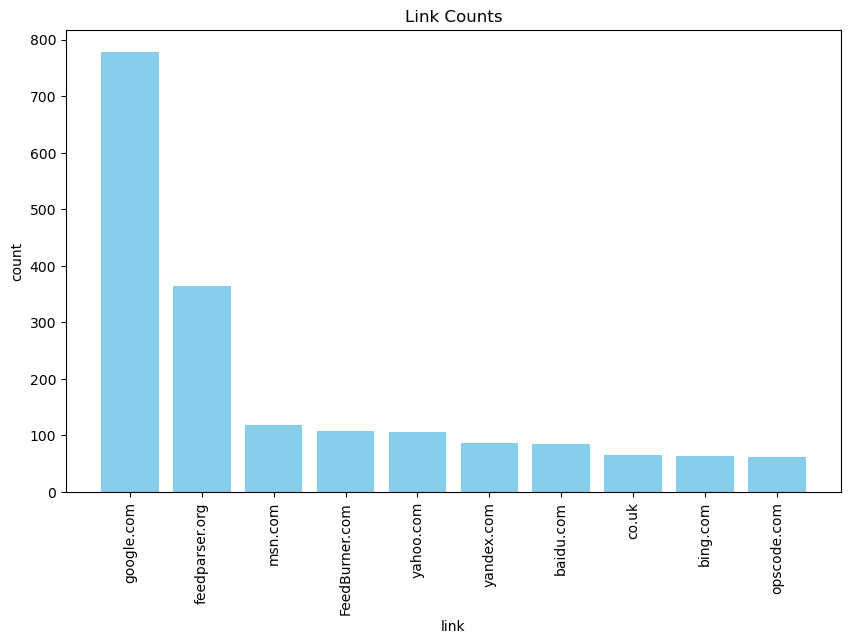

In [10]:
xs, ys = zip(*link_counts)
draw_bar_plot(xs, ys, 'link', 'count', 'Link Counts')


### Most common graphic file extension

In [11]:
# regex based on: https://regex101.com/r/jrWpwL/1
graphic_file_regex = r'(?:gif|jpeg|jpg|pdf|png|tiff|tif|psd|eps|bmp)\b'
top_n = 10

graphic_file_counts = (lines
    .map(lambda log: re.findall(graphic_file_regex, log))
    .flatMap(lambda matches: [(match, 1) for match in matches])
    .reduceByKey(lambda a, b: a + b)
    .map(lambda x: (x[0].lstrip('/'), x[1])) # files started with / e.g ('/jordan-80.png', 533)
    .takeOrdered(top_n, key=lambda x: -x[1])
)

graphic_file_counts

[('png', 2340), ('jpg', 257), ('gif', 228), ('pdf', 138), ('jpeg', 5)]

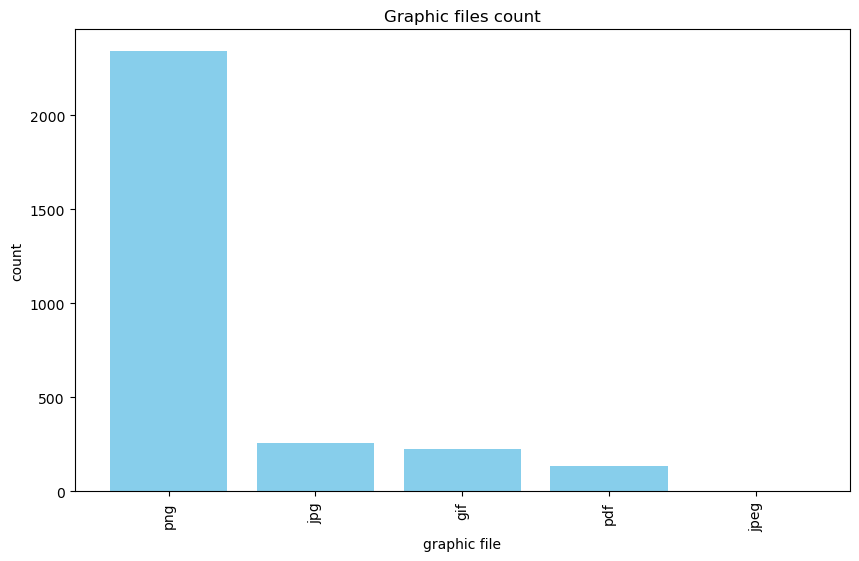

In [12]:
xs, ys = zip(*graphic_file_counts)
draw_bar_plot(xs, ys, 'graphic file', 'count', 'Graphic files count')

### Requests response codes per 24h

In [13]:
day_regex = "\[(\d{1,2})"
hour_regex = "\[\d+/\w+/\d+:(\d+)"
response_code_regex = "\"(GET|HEAD|POST|OPTIONS).*?\" (\d+)"

def get_day_hour_and_response_code(log):
    day = int(re.search(day_regex, log).group(1))
    hour = int(re.search(hour_regex, log).group(1))
    response_code = int(re.search(response_code_regex, log).group(2))
    return (day, hour, response_code), 1

requests_counts = (lines
    .map(lambda log: get_day_hour_and_response_code(log))
    .reduceByKey(lambda a, b : a + b)
    .map(lambda x: [x[0][0], x[0][1], x[0][2], x[1]])  # Map to [day, hour, response_code, count]
    .collect()
)

for requests_count in requests_counts[:5]:
    print(requests_count)

[17, 10, 200, 73]
[17, 10, 404, 1]
[17, 11, 301, 1]
[17, 12, 200, 109]
[17, 12, 304, 4]


/opt/conda/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/opt/conda/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/opt/conda/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/opt/conda/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **p

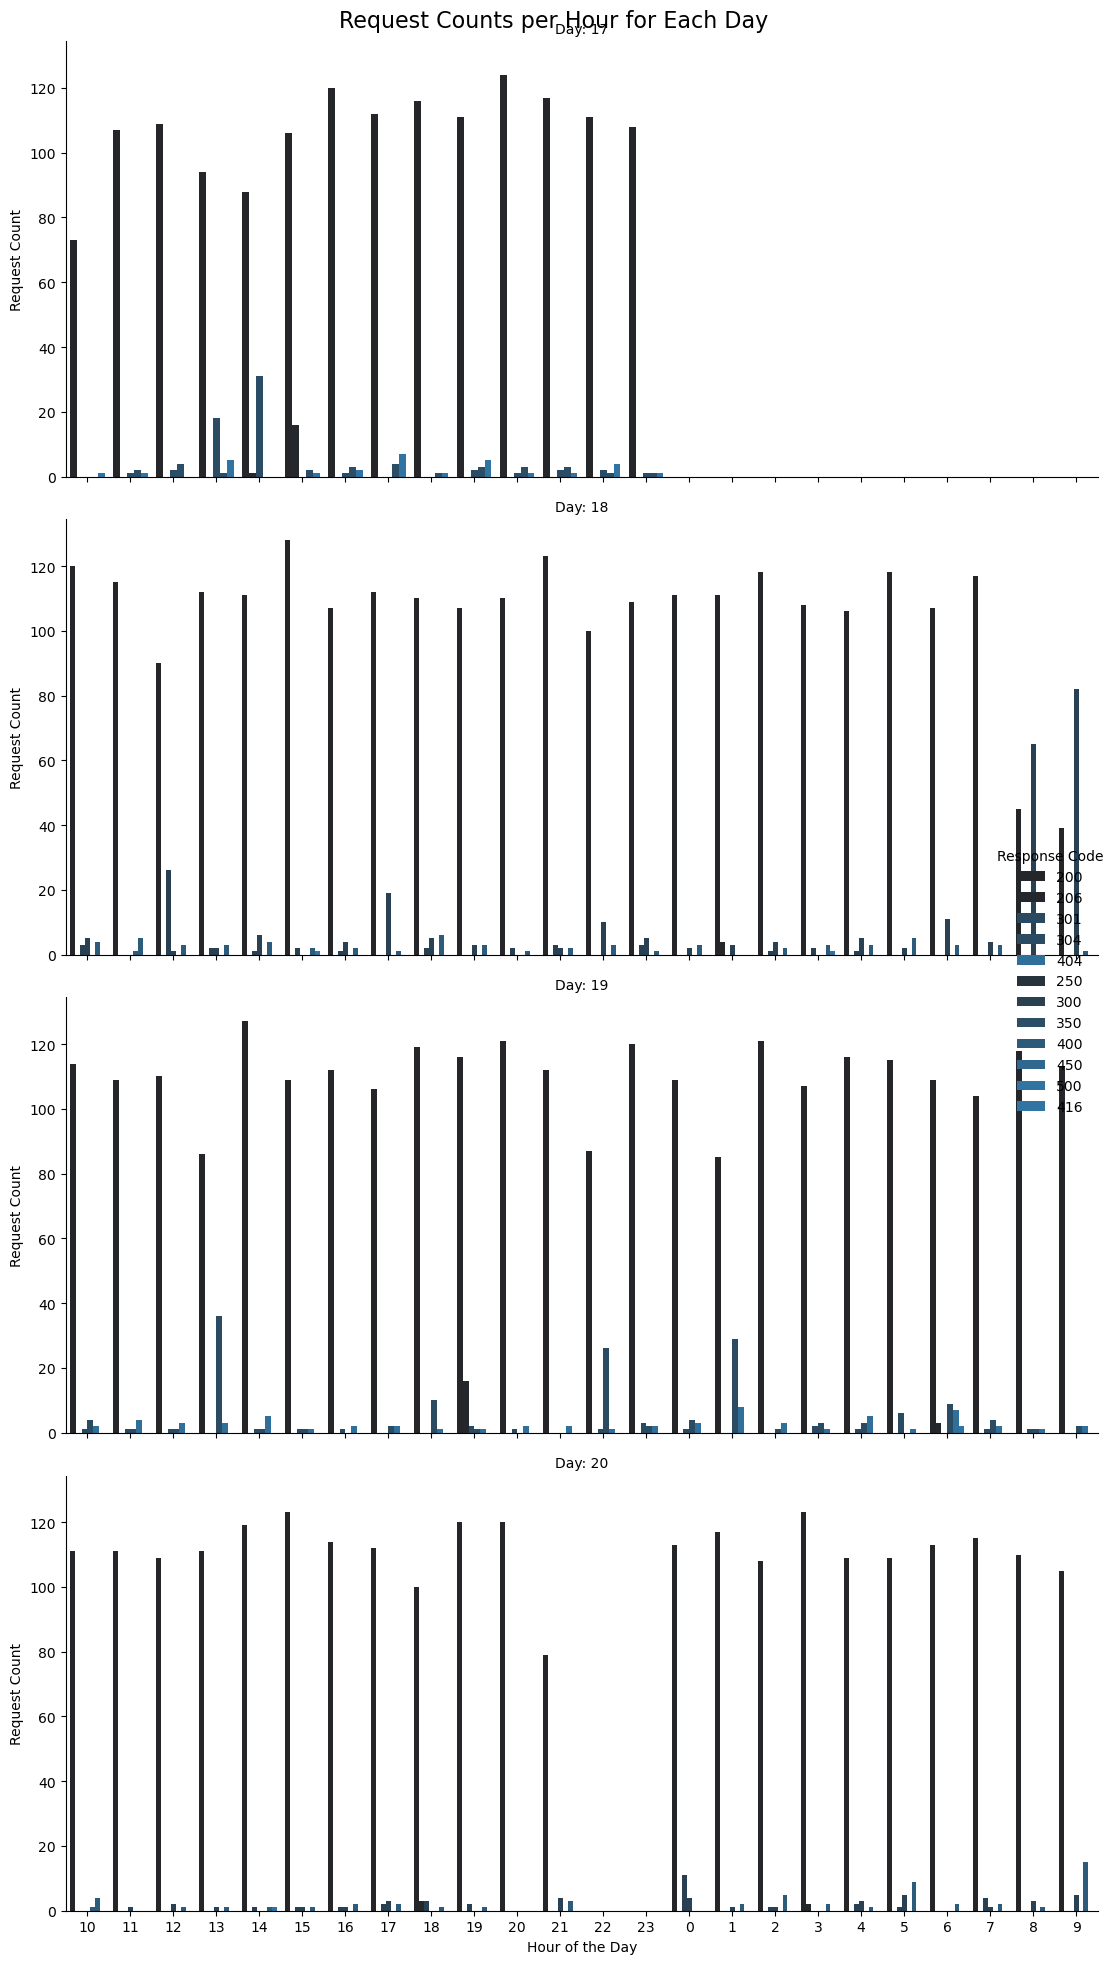

In [14]:
# PLOT GENERATED USING AI CHAT

# Create DataFrame from requests_counts
df = pd.DataFrame(
    data=requests_counts,
    columns=["day", "hour", "code", "count"]
)

# Create a bar plot using FacetGrid to separate plots by day
# Adjusting height and aspect for wider and taller plots
g = sns.FacetGrid(df, col="day", col_wrap=1, height=5, aspect=2)  # Increased height
g.map_dataframe(sns.barplot, x="hour", y="count", hue="code")
g.add_legend(title="Response Code")

# Adjusting the titles and labels
g.set_axis_labels("Hour of the Day", "Request Count")
g.set_titles(col_template="Day: {col_name}")
g.fig.suptitle('Request Counts per Hour for Each Day', fontsize=16)  # Adjust y for title

plt.xticks(rotation=0)  # Rotate x labels for better readability
plt.tight_layout()  # Adjust layout for better appearance
plt.show()

### OS popularity 

In [15]:
os_regex = r'\(([^)]+\d)'

os_counts = (lines
    .map(lambda log: re.findall(os_regex, log))
    .flatMap(lambda matches: [(match, 1) for match in matches])
    .reduceByKey(lambda a, b: a + b)
    .map(lambda x: (x[0].lstrip('/'), x[1])) # files started with / e.g ('/jordan-80.png', 533)
    .takeOrdered(top_n, key=lambda x: -x[1])
)
os_counts

[('Windows NT 6.1; WOW64', 1198),
 ('Macintosh; Intel Mac OS X 10_9_1', 692),
 ('X11; Linux x86_64', 688),
 ('compatible; Googlebot/2.1', 510),
 ('Windows NT 6.1; WOW64; rv:27.0', 296),
 ('iPhone; CPU iPhone OS 6_0', 273),
 ('X11; Ubuntu; Linux x86_64; rv:27.0', 236),
 ('X11; Linux x86_64; rv:27.0', 231),
 ('Windows NT 6.3; WOW64', 214),
 ('Macintosh; Intel Mac OS X 10.7; rv:22.0', 166)]

Text(0.5, 1.0, 'OS popularity chart')

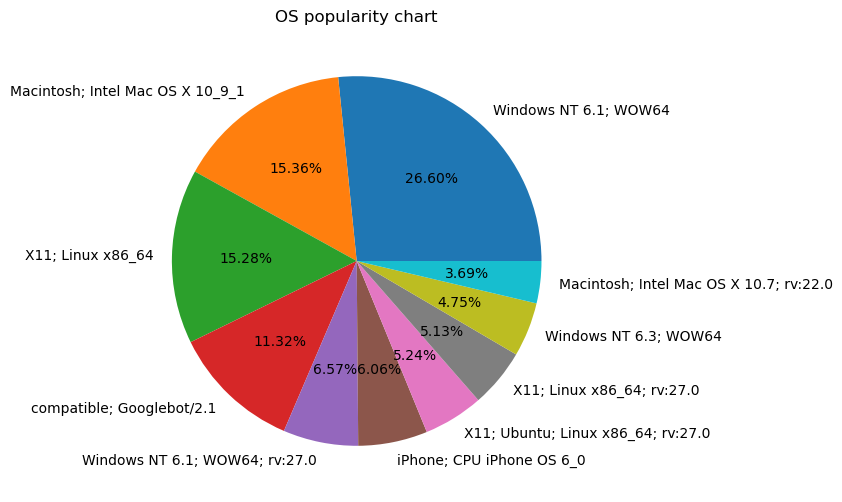

In [16]:
xs, ys = zip(*os_counts)

plt.figure(figsize=(10, 6))
plt.pie(ys, labels=xs, autopct='%1.2f%%')
plt.title('OS popularity chart')


### Estimate what percentage of traffic is generated by bots in two different approaches

Method 1.  Filtering Based on Known Bot User Agents

In [17]:
# bot names from: https://deviceatlas.com/blog/most-active-crawlers-list
bot_names = {
    "Googlebot",
    "OkHttp library",
    "Headless Chrome",
    "Python HTTP library",
    "cURL",
    "Nessus",
    "Facebook",
    "Bingbot",
    "AhrefsBot",
    "SemrushBot",
    "Chrome-Lighthouse",
    "Adbeat",
    "Comscore",
    'Proximic'
    "Bytespider",
    "PetalBot"
}

bot_traffic = (lines
               .filter(lambda log: any(bot in log for bot in bot_names))
               .count()
              )

bot_traffic_perc = 100 * (bot_traffic / lines.count())

print(f'Estimated bot traffic: {bot_traffic_perc:.2f} [%]')

Estimated bot traffic: 5.77 [%]


Method 2. Analyzing Traffic Patterns

In [18]:
# ip regex from 
ip_address_regex = r'(?:(?:25[0-5]|2[0-4][0-9]|1[0-9]{2}|[1-9]?[0-9])\.){3}(?:25[0-5]|2[0-4][0-9]|1[0-9]{2}|[1-9]?[0-9])'

# any IPs with over 100 requests are identified as potential bots
request_limit = 100

bot_traffic_counts = (lines
    .map(lambda log: re.findall(ip_address_regex, log))
    .flatMap(lambda matches: [(match, 1) for match in matches])
    .reduceByKey(lambda a, b: a + b)
    .filter(lambda x: x[1] > request_limit)
    .map(lambda x: x[1])
    .sum()
)

bot_traffic_perc = 100 * (bot_traffic_counts / lines.count())

print(f'Estimated bot traffic: {bot_traffic_perc:.2f} [%]')

Estimated bot traffic: 16.91 [%]


#### Location of customers on map

In [19]:
ip_addresses = (lines
    .flatMap(lambda log: re.findall(ip_address_regex, log))
    .distinct()
    .collect()
)

In [20]:
# Fetch the token from the environment variable

# TOKEN = os.getenv('IPINFO_TOKEN') # token from https://ipinfo.io/

def get_lat_long(ip):
    try:
        # response = requests.get(f'https://ipinfo.io/{ip}/json?token={TOKEN}')
        response = requests.get(f'https://ipinfo.io/{ip}/json')
        if response.status_code != 200:
            print(f"Error fetching data for IP {ip}: {response.status_code}")
            return None
            
        data = response.json()
        
        loc = data.get('loc', None)    
        if not loc:
            return None
            
        lat, lon = map(float, loc.split(','))
        return lat, lon
        
    except Exception as e:
        print(f"An error occurred for IP {ip}: {e}")
        return None

# Get coordinates for each IP address
coordinates = [get_lat_long(ip) for ip in ip_addresses]


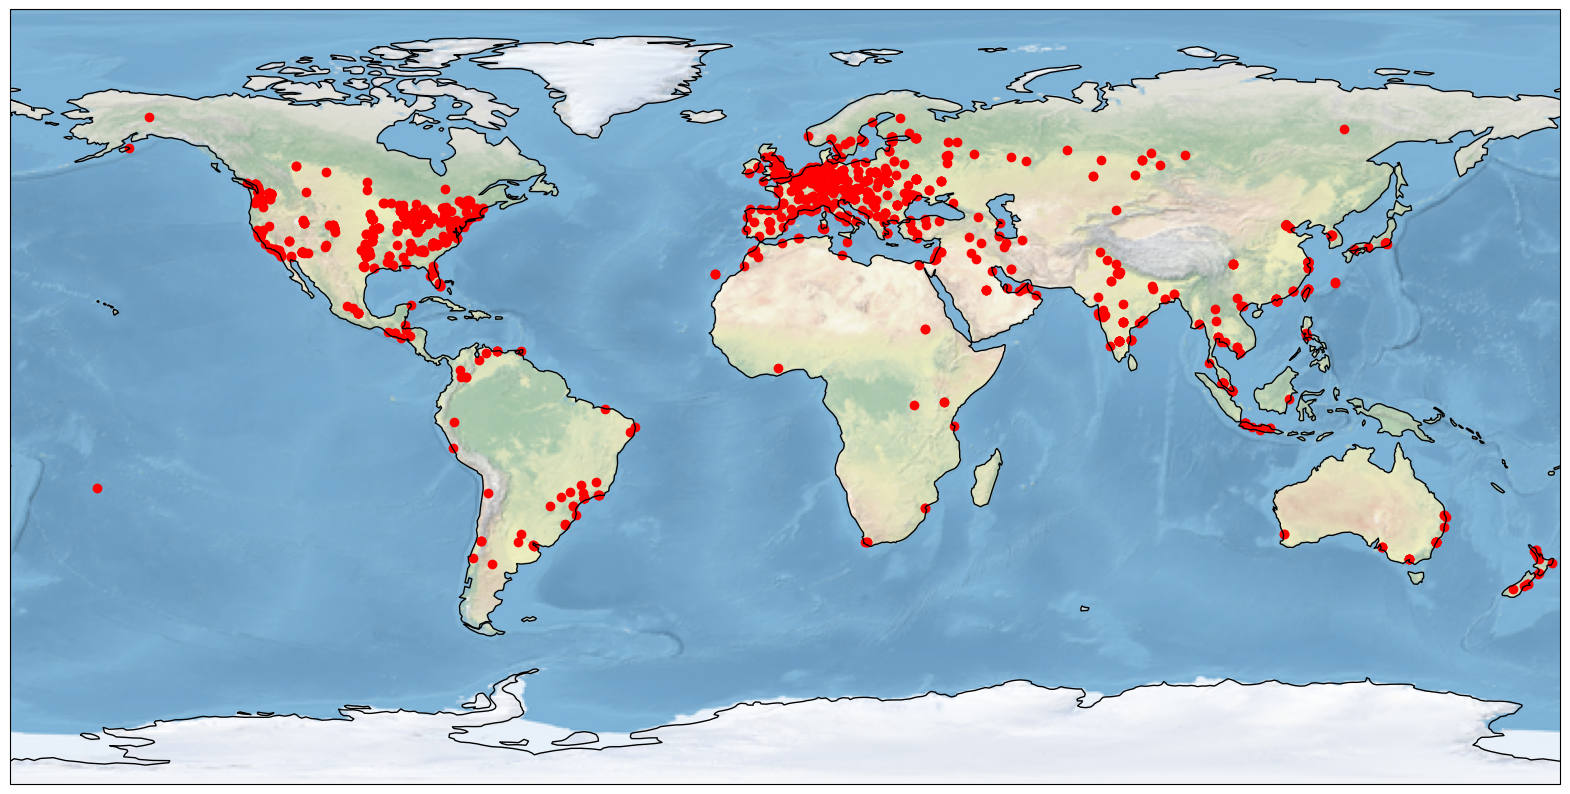

In [22]:
# Filter out None values
coordinates = list(filter(lambda x: x is not None, coordinates))

# Create a map
fig = plt.figure(figsize=(20, 20))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.coastlines()


lats, longs = zip(*coordinates)
plt.scatter(
    x = longs,
    y = lats,
    color = 'r',
)

plt.show()